# Embedding of the Harry Potter Multiplex

## Preprocessing

In [228]:
# import statements
import numpy as np
import networkx as nx
import regex as re 
import os
import matplotlib.pyplot as plt
import pandas as pd
import random 
import graspologic
import math

In [193]:
#read in networks
book_titles = ["The Philosopher's Stone",
              "The Chamber of Secrets",
              "The Prisoner of Azkaban",
              "The Goblet of Fire",
              "The Order of the Phoenix",
              "The Half Blood Prince",
              "The Deathly Hallows"]
fnames = [re.sub("'", '', re.sub(' ', '_', title[4:])) + '_adj_matrix' for title in book_titles]
path = os.getcwd() + '/../adj_matrices/'
A_mats = [np.loadtxt(path + fname) for fname in fnames]
cols = ['pink','orange','red', 'darkcyan', 'green', 'blue', 'purple']

In [194]:
# read in dictionaries
def read_dict(fname):
    path = os.getcwd() + '/../dictionaries/'
    s = open(path + fname, 'r').read()
    d = dict(eval(s))
    return d

name_to_id = read_dict('name_to_id')
id_to_name = read_dict('id_to_name')
characters = eval(open(os.getcwd() + '/../dictionaries/characters_list', 'r').read())

In [266]:
#subset to only core component
ids_to_keep = []; ids_to_drop = []
id_to_name_arr = {}; name_to_id_arr = {}
count_in = 0
char_importance = []
for i in range(len(characters)):
    #define character importance
    degs = np.array([A[i,i] for A in A_mats])
    char_importance += [np.mean(degs)]
    
    #threshold for core / no core
    if char_importance[i] > 3: 
        ids_to_keep += [i]
        id_to_name_arr[count_in] = id_to_name[i]
        name_to_id_arr[id_to_name[i]] = count_in
        count_in += 1 
    else: 
        ids_to_drop += [i]
        
#fill droped ids to dicts
for j in range(len(ids_to_drop)):
    id_to_name_arr[count_in + j] = id_to_name[j]
    name_to_id_arr[id_to_name[j]] = count_in + j


In [267]:
#rearrange adjacency matrices to have in and out of core in blocks
inds = ids_to_keep + ids_to_drop
A_mats_arr = [A[inds, :][:, inds] for A in A_mats]

#core only and between adjacencies
n1 = len(ids_to_keep); n2 = len(id_to_name_arr) - n1
A_mats_cc = [A[:n1,:n1] for A in A_mats_arr]
A_mats_between = [A[n1:,:n1] for A in A_mats_arr]

print(A_mats_cc[0].shape, A_mats_between[0].shape,n1, n2)

(98, 98) (113, 98) 98 113


In [268]:
#binarize matrices, normalize Frobenius norm, place make network objects
thres = 0

#fully arranged matrices
A_mats_arr_binary = [np.where(A > thres, 1, 0) for A in A_mats_arr] 
graphs_arr = [nx.from_numpy_matrix(A / np.linalg.norm(A, 'fro')) for A in A_mats_arr_binary]

#core component
A_mats_cc_binary = [np.where(A > thres, 1, 0) for A in A_mats_cc]
graphs_cc = [nx.from_numpy_matrix(A / np.linalg.norm(A, 'fro')) for A in A_mats_cc_binary]

#binarize between matrices, normalize Frobenius norm of core component
A_mats_between_binary = [np.where(A > thres, 1, 0) for A in A_mats_between]
A_mats_between_binary = [A_mats_between_binary[i] /np.linalg.norm(A_mats_cc_binary[i], 'fro')  for i in range(len(A_mats_between_binary))]

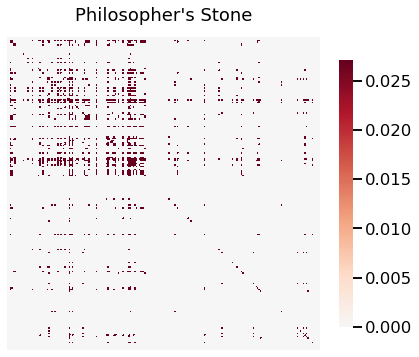

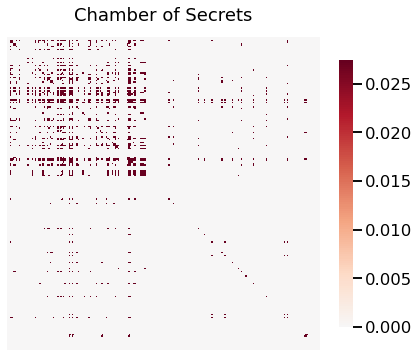

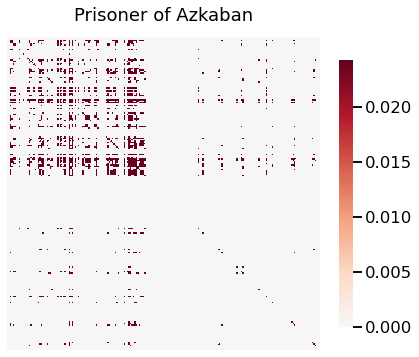

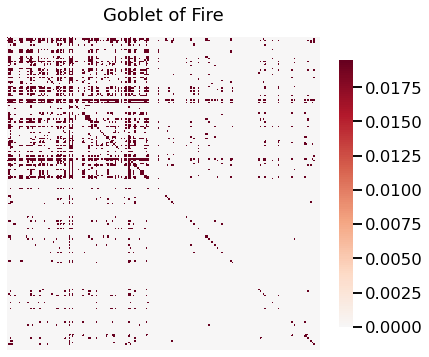

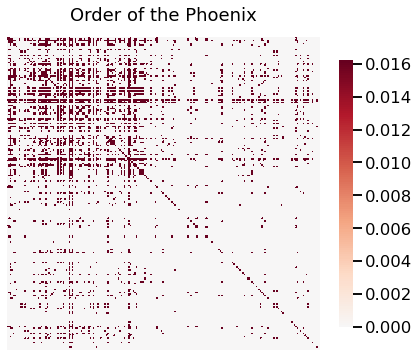

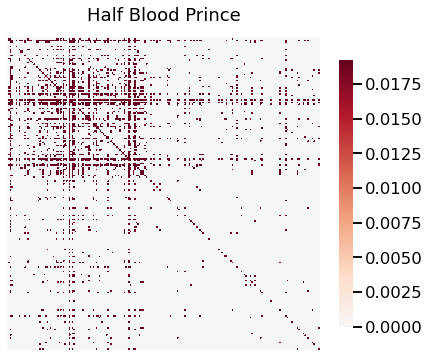

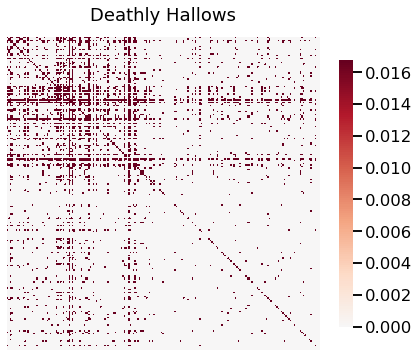

In [269]:
# Visualize in heatmaps
from graspologic.plot import heatmap

for i, title in enumerate(book_titles):
    heatmap(graphs_arr[i], figsize=(7, 7), title=title[4:])

In [276]:
# Core embeddding
random.seed(1985)
from graspologic.embed import OmnibusEmbed
d = 4
embedder = OmnibusEmbed(n_components=d)
Xhat = embedder.fit_transform(graphs_cc)

# Out of core embeddding
Yhat = [A_mats_between_binary[i] @ np.linalg.pinv(Xhat[i]).T for i in range(len(Xhat))]

#Concatenate
Zhat = [np.concatenate((Xhat[i], Yhat[i]), axis = 0) for i in range(len(Xhat))]

(211, 4)


Text(0.5, 1.0, 'Average Latent Positions from Omnibus Embedding')

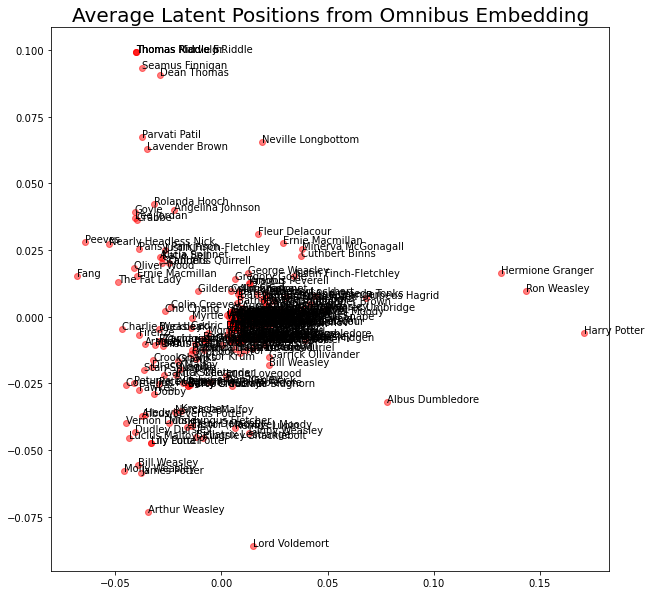

In [277]:
#plot average to see what's happening
X_ave = sum(Zhat) / len(Zhat)
print(X_ave.shape)
#dims
dim0, dim1 = 1, 2

# Plot the points
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_ave[:, dim0], X_ave[:, dim1], marker='o', color = 'red', alpha = 0.5)
#ax.scatter(Xhat2[:, 0], Xhat2[:, 1], marker='o')

for i, txt in id_to_name_arr.items():
    ax.annotate(txt, (X_ave[i, dim0], X_ave[i, dim1]))


ax.set_title('Average Latent Positions from Omnibus Embedding', fontsize=20)

In [278]:
def visualize_embeddings(latent_pos, colors, scale_x = 1, scale_y = 1, 
                         title = '', file_handle = '', label_dict = None):    
    #get embedding dimension 
    d_lst = [pos.shape[1] for pos in latent_pos]
    m = len(latent_pos)
    n = latent_pos[0].shape[0]
    dmax = max(d_lst)
    
    #set up figure size
    fig = plt.figure(figsize = (10*m*scale_x, 10*(dmax-1)*scale_y))
    for g in range(len(latent_pos)):
        for i in range(d_lst[g]-1):                
         #plot figure
            dim_labels = ['Dim.' + str(i+1), 'Dim.' + str(i+2)]
            ax = fig.add_subplot(m, d_lst[g]-1, (d_lst[g]-1)*g+(i+1))
            plt.scatter(latent_pos[g][:,i], latent_pos[g][:, i+1], 
                        color = colors[g], alpha = 0.5, s = 1000 * math.log(n)/n)
            if label_dict != None:
                for j, txt in label_dict.items():
                    ax.annotate(txt, (latent_pos[g][j,i], latent_pos[g][j,i+1]))
            if title == '':
                ax.title.set_text('Graph ' + str(g+1))
            else:
                ax.title.set_text(title)
            ax.set_xlabel(dim_labels[0])
            ax.set_ylabel(dim_labels[1])

    
    #show figure
    plt.subplots_adjust(wspace= 1/scale_x * 0.1, hspace = 1/scale_y * 0.2)
    if file_handle != '':
        plt.savefig(file_handle)
    plt.show()

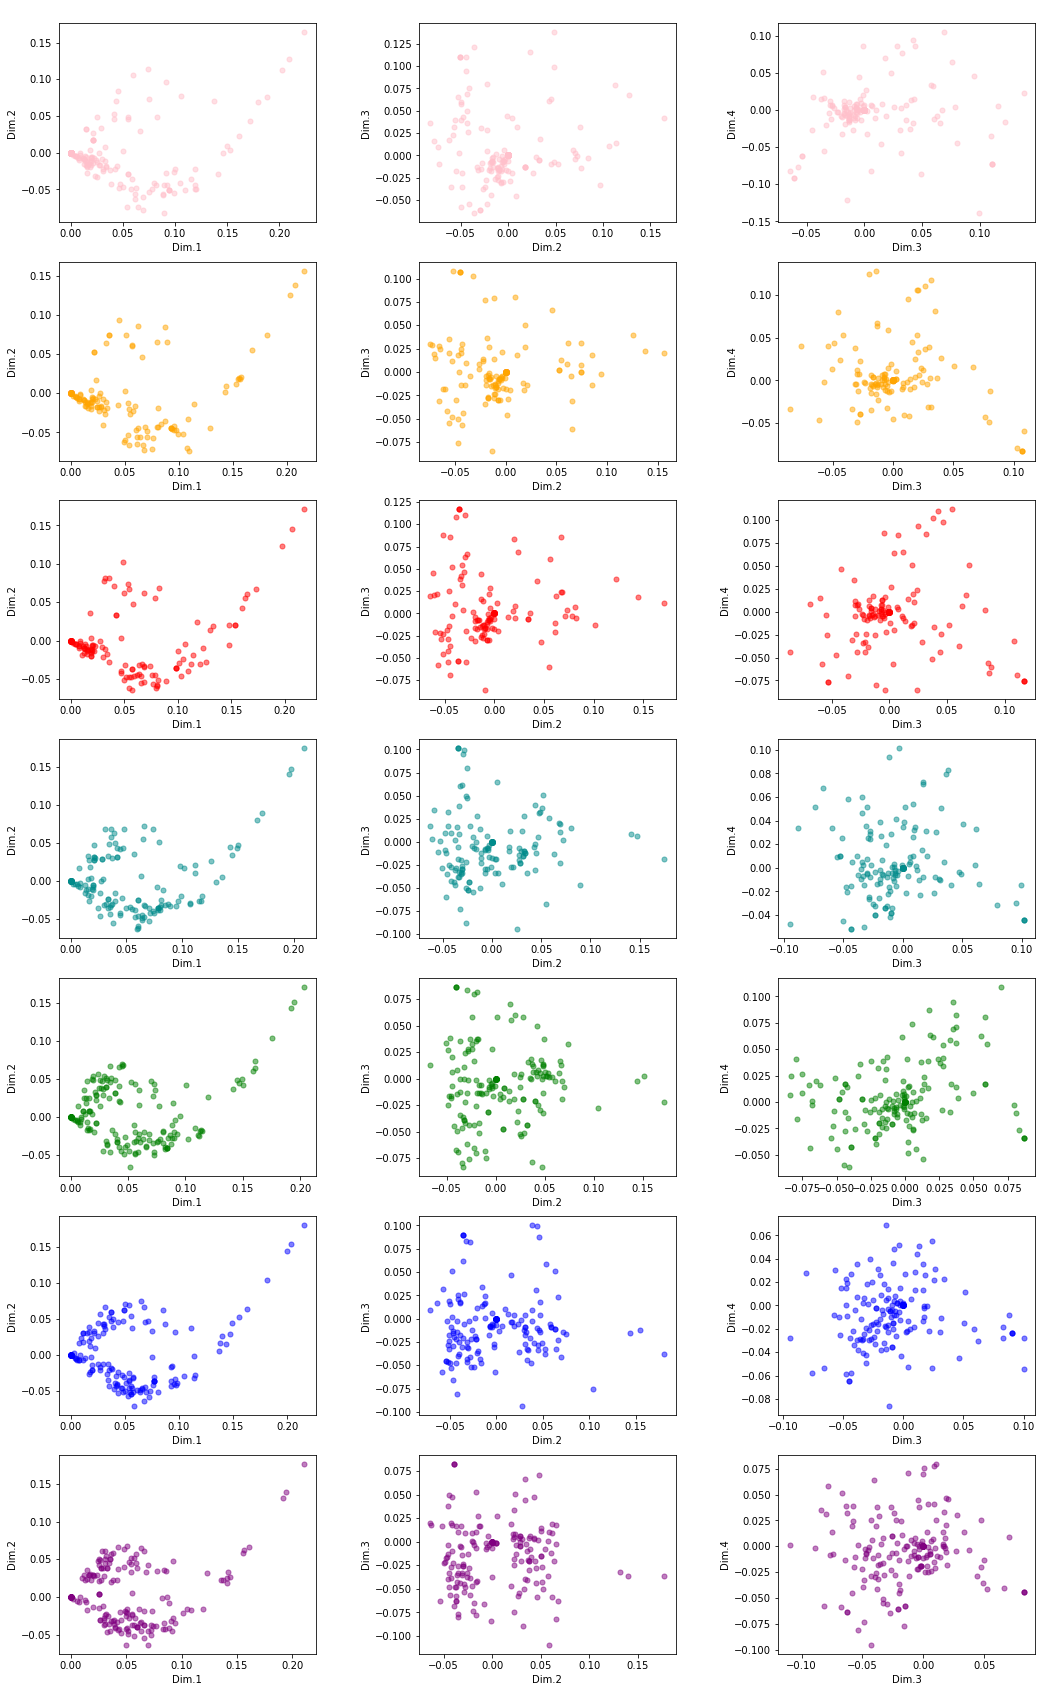

In [279]:
visualize_embeddings(Zhat, colors = cols, scale_x = 0.25, scale_y = 1, title = ' ')#,  label_dict = id_to_name_arr, file_handle='../figures/omnibus_embedding_by_graph.png')